In [10]:
import arviz as az
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano.tensor as tt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]

In [2]:
az.style.use("arviz-darkgrid")


def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

Import election results as well as city-level (`unemployment`) predictor:

In [3]:
d = pd.read_csv("demo_results_and_preds.csv", index_col=0)
d

arrondissement        date  ville      N  farleft   left  green  center  \
0                 1  2007-04-22  Paris   9152      239   2530    205    2051   
1                 1  2007-06-10  Paris   6825      243      0   1969     818   
2                 1  2008-03-09  Paris   6127       75   2289    439     531   
3                 1  2009-06-07  Paris   5212      275    665   1493     419   
4                 1  2010-03-14  Paris   4843      295   1077   1038     177   
..              ...         ...    ...    ...      ...    ...    ...     ...   
235              20  2014-03-23  Paris  54966     5692  20502   5990       0   
236              20  2014-05-25  Paris  49075     4974  10575   9498    4218   
237              20  2015-12-06  Paris  49130     6100  18315   7348       0   
238              20  2017-04-23  Paris  89574    28512  12469      0   27399   
239              20  2017-06-11  Paris  57413    11546  10700   7766    6505   

     right  farright  other         type  unemployment      csp_plus  \
0     3595       418    114    president           7.8   4886.163367   
1     3430       158    207  legislative           7.8   4886.163367   
2     2641       152      0   municipale           6.6   5042.215106   
3     1808       127    425     european           7.9   5121.184955   
4     1758       261    237     regional           8.2   5126.709956   
..     ...       ...    ...          ...           ...           ...   
235  11467      4112   7203   municipale           8.7  32923.619569   
236   5994      4584   9232     european           8.8  32923.619569   
237   8340      4977   4050     regional           8.7  33664.134135   
238  11451      5305   4438    president           8.0  34330.223246   
239   4300      2446  14150  legislative           8.0  34330.223246   

          pop2554  
0     8915.091416  
1     8915.091416  
2     8845.308159  
3     8967.554268  
4     8886.736184  
..            ...  
235  90139.233180  
236  90139.233180  
237  89863.300140  
238  90336.126337  
239  90336.126337  

[240 rows x 15 columns]

Import poll aggregation for each election (city-level):

In [4]:
aggregated_polls = pd.read_csv("demo_aggregated_polls.csv", index_col=0)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)

# replace 0 (i.e party not available) by very small values to avoid -inf when taking the log:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0, value=aggregated_polls.green_agg.iloc[-2]
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513        -2.63     -0.43   
1   legislatives   2007-06-10             916        -1.61     -0.29   
2     municipale   2008-03-09             755        -2.33      0.19   
3    europeennes   2009-06-07            2287        -1.04     -0.63   
4     regionales   2010-03-14             907        -1.32     -0.24   
5      president   2012-04-22            1400        -0.99     -0.29   
6   legislatives   2012-06-10            1193        -1.53     -0.14   
7     municipale   2014-03-23             977        -1.88      0.04   
8    europeennes   2014-05-25            3248        -1.58     -0.79   
9     regionales   2015-12-06            1749        -1.94     -0.47   
10     president   2017-04-23            1555        -0.67     -1.57   
11  legislatives   2017-06-11            1299        -1.14     -1.53   

    green_agg  center_agg  right_agg  farright_agg  
0       -3.95       -0.67      -0.30         -0.95  
1       -2.30       -1.20       0.12         -1.76  
2       -1.85       -1.51      -0.12         -2.82  
3       -1.01       -1.19      -0.30         -1.85  
4       -1.00       -2.06      -0.24         -1.40  
5       -2.68       -1.27      -0.32         -0.84  
6       -1.98       -2.58      -0.09         -0.88  
7       -1.73      -22.24      -0.01         -1.50  
8       -1.42       -1.33      -0.54         -0.46  
9       -1.84      -22.24      -0.27         -0.24  
10     -22.24       -0.44      -0.64         -0.49  
11      -2.51       -0.19      -0.56         -0.75

Join polling aggregation:

In [7]:
d = d.merge(
    aggregated_polls.drop("type", 1),
    left_on="date",
    right_on="dateelection",
    how="left",
).drop("dateelection", 1)
d

arrondissement        date  ville      N  farleft   left  green  center  \
0                 1  2007-04-22  Paris   9152      239   2530    205    2051   
1                 1  2007-06-10  Paris   6825      243      0   1969     818   
2                 1  2008-03-09  Paris   6127       75   2289    439     531   
3                 1  2009-06-07  Paris   5212      275    665   1493     419   
4                 1  2010-03-14  Paris   4843      295   1077   1038     177   
..              ...         ...    ...    ...      ...    ...    ...     ...   
235              20  2014-03-23  Paris  54966     5692  20502   5990       0   
236              20  2014-05-25  Paris  49075     4974  10575   9498    4218   
237              20  2015-12-06  Paris  49130     6100  18315   7348       0   
238              20  2017-04-23  Paris  89574    28512  12469      0   27399   
239              20  2017-06-11  Paris  57413    11546  10700   7766    6505   

     right  farright  ...  unemployment      csp_plus       pop2554  \
0     3595       418  ...           7.8   4886.163367   8915.091416   
1     3430       158  ...           7.8   4886.163367   8915.091416   
2     2641       152  ...           6.6   5042.215106   8845.308159   
3     1808       127  ...           7.9   5121.184955   8967.554268   
4     1758       261  ...           8.2   5126.709956   8886.736184   
..     ...       ...  ...           ...           ...           ...   
235  11467      4112  ...           8.7  32923.619569  90139.233180   
236   5994      4584  ...           8.8  32923.619569  90139.233180   
237   8340      4977  ...           8.7  33664.134135  89863.300140   
238  11451      5305  ...           8.0  34330.223246  90336.126337   
239   4300      2446  ...           8.0  34330.223246  90336.126337   

     samplesize_agg  farleft_agg  left_agg  green_agg  center_agg  right_agg  \
0              1513    -2.633513 -0.432471  -3.950292   -0.670963  -0.296018   
1               916    -1.613136 -0.288538  -2.295177   -1.196553   0.116238   
2               755    -2.327655  0.190572  -1.849138   -1.513482  -0.116553   
3              2287    -1.040641 -0.628886  -1.013539   -1.192074  -0.299655   
4               907    -1.319981 -0.240301  -0.996263   -2.061018  -0.240266   
..              ...          ...       ...        ...         ...        ...   
235             977    -1.884055  0.037657  -1.727255  -22.243938  -0.005215   
236            3248    -1.582788 -0.790411  -1.420928   -1.334419  -0.537229   
237            1749    -1.943570 -0.473766  -1.836909  -22.243938  -0.268955   
238            1555    -0.667318 -1.565596 -22.243938   -0.437694  -0.640817   
239            1299    -1.144984 -1.528224  -2.510045   -0.191539  -0.560378   

     farright_agg  
0       -0.946153  
1       -1.763649  
2       -2.824834  
3       -1.854871  
4       -1.398709  
..            ...  
235     -1.496337  
236     -0.460404  
237     -0.241968  
238     -0.493163  
239     -0.747776  

[240 rows x 22 columns]

Define useful index variables for the model:

In [8]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

Nparties = len(PARTIES) - 1
N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values
parties_available

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

Define and run the model:

In [9]:
with pm.Model() as m_var_effects:
    mus_parties = []
    log_unemployment = pm.Data(
        "log_unemployment", stdz(np.log(d["unemployment"].values))
    )
    for p_id, p in enumerate(PARTIES_AGG):
        stdz_polls = pm.Data(f"{p}", stdz(d[p]).values)
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(3.0)
        packed_chol = pm.LKJCholeskyCov(
            f"chol_cov_p{p_id}", eta=2, n=3, sd_dist=sd_dist
        )

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p_id}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p_id}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        if p in ["left_agg", "center_agg", "right_agg"]:
            ab = pm.Normal(
                f"ab_p{p_id}",
                mu=np.array([-1.4, 0.0, 0.1]),
                sd=np.array([0.5, 0.05, 0.05]),
                shape=3,
            )
        elif p in ["farleft_agg", "green_agg"]:
            ab = pm.Normal(
                f"ab_p{p_id}",
                mu=np.array([-1.9, 0.0, 0.1]),
                sd=np.array([0.5, 0.05, 0.05]),
                shape=3,
            )
        elif p == "farright_agg":
            ab = pm.Normal(
                f"ab_p{p_id}",
                mu=np.array([-2.7, 0.0, 0.0]),
                sd=np.array([0.5, 0.05, 0.05]),
                shape=3,
            )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p_id}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * log_unemployment
            + ab_district[district_id, 2] * stdz_polls
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T
    # append last category:
    vary_pivot = pm.Deterministic(
        "vary_pivot",
        tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-3.0)),
    )
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for all elections:
    p_latent = pm.Deterministic("p_latent", tt.nnet.softmax(mus_parties))
    # zero-inflation process:
    # keep only preferences for available parties:
    p_district = parties_available * p_latent
    # renormalize preferences:
    p_district = pm.Deterministic(
        "p_district", p_district / tt.sum(p_district, axis=1, keepdims=True)
    )

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs)

In [124]:
with m_var_effects:
    trace_var_effects = pm.sample(
        1000, tune=2000, random_seed=RANDOM_SEED, init="adapt_diag",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_district_p5, β_p5, chol_cov_p5, β_district_p4, β_p4, chol_cov_p4, β_district_p3, β_p3, chol_cov_p3, β_district_p2, β_p2, chol_cov_p2, β_district_p1, β_p1, chol_cov_p1, β_district_p0, β_p0, chol_cov_p0]


In [125]:
az.summary(trace_var_effects, round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
β_p0[0]            -2.51  0.27   -3.00    -2.00        0.0      0.0   3256.42   
β_p0[1]            -0.05  0.05   -0.14     0.05        0.0      0.0   6608.70   
β_p0[2]             0.28  0.05    0.18     0.38        0.0      0.0   3250.50   
β_district_p0[0,0] -2.88  0.03   -2.93    -2.83        0.0      0.0   2567.94   
β_district_p0[0,1] -0.70  0.03   -0.77    -0.64        0.0      0.0   2335.08   
...                  ...   ...     ...      ...        ...      ...       ...   
p_district[239,2]   0.10  0.00    0.10     0.10        0.0      0.0   4785.33   
p_district[239,3]   0.25  0.00    0.24     0.25        0.0      0.0   4501.27   
p_district[239,4]   0.11  0.00    0.11     0.12        0.0      0.0   5866.71   
p_district[239,5]   0.06  0.00    0.06     0.06        0.0      0.0   6469.16   
p_district[239,6]   0.12  0.00    0.12     0.12        0.0      0.0   3401.38   

                     ess_sd  ess_bulk  ess_tail  r_hat  
β_p0[0]             3256.42   3327.30   2604.42    1.0  
β_p0[1]             4077.24   6604.82   3478.17    1.0  
β_p0[2]             3250.50   3348.62   2691.95    1.0  
β_district_p0[0,0]  2567.42   2563.24   2949.32    1.0  
β_district_p0[0,1]  2326.16   2347.91   2711.78    1.0  
...                     ...       ...       ...    ...  
p_district[239,2]   4785.33   4792.66   3052.48    1.0  
p_district[239,3]   4497.64   4514.72   3263.98    1.0  
p_district[239,4]   5866.71   5846.44   3189.18    1.0  
p_district[239,5]   6468.56   6460.56   3451.56    1.0  
p_district[239,6]   3401.38   3409.96   2966.26    1.0  

[3888 rows x 11 columns]

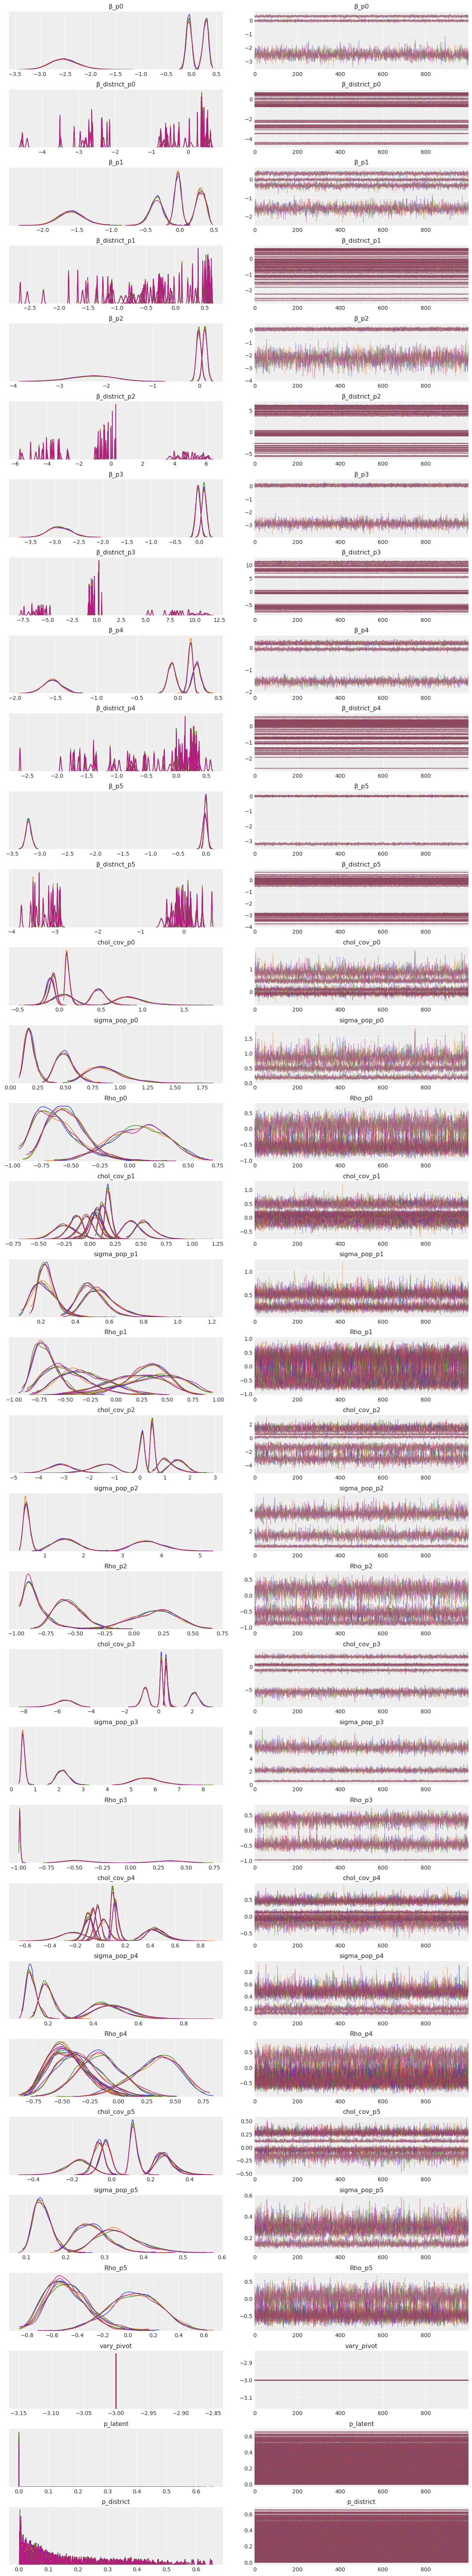

In [126]:
az.plot_trace(trace_var_effects, compact=True);

In [127]:
share_est = trace_var_effects["p_district"]
share_mean = share_est.mean(0)

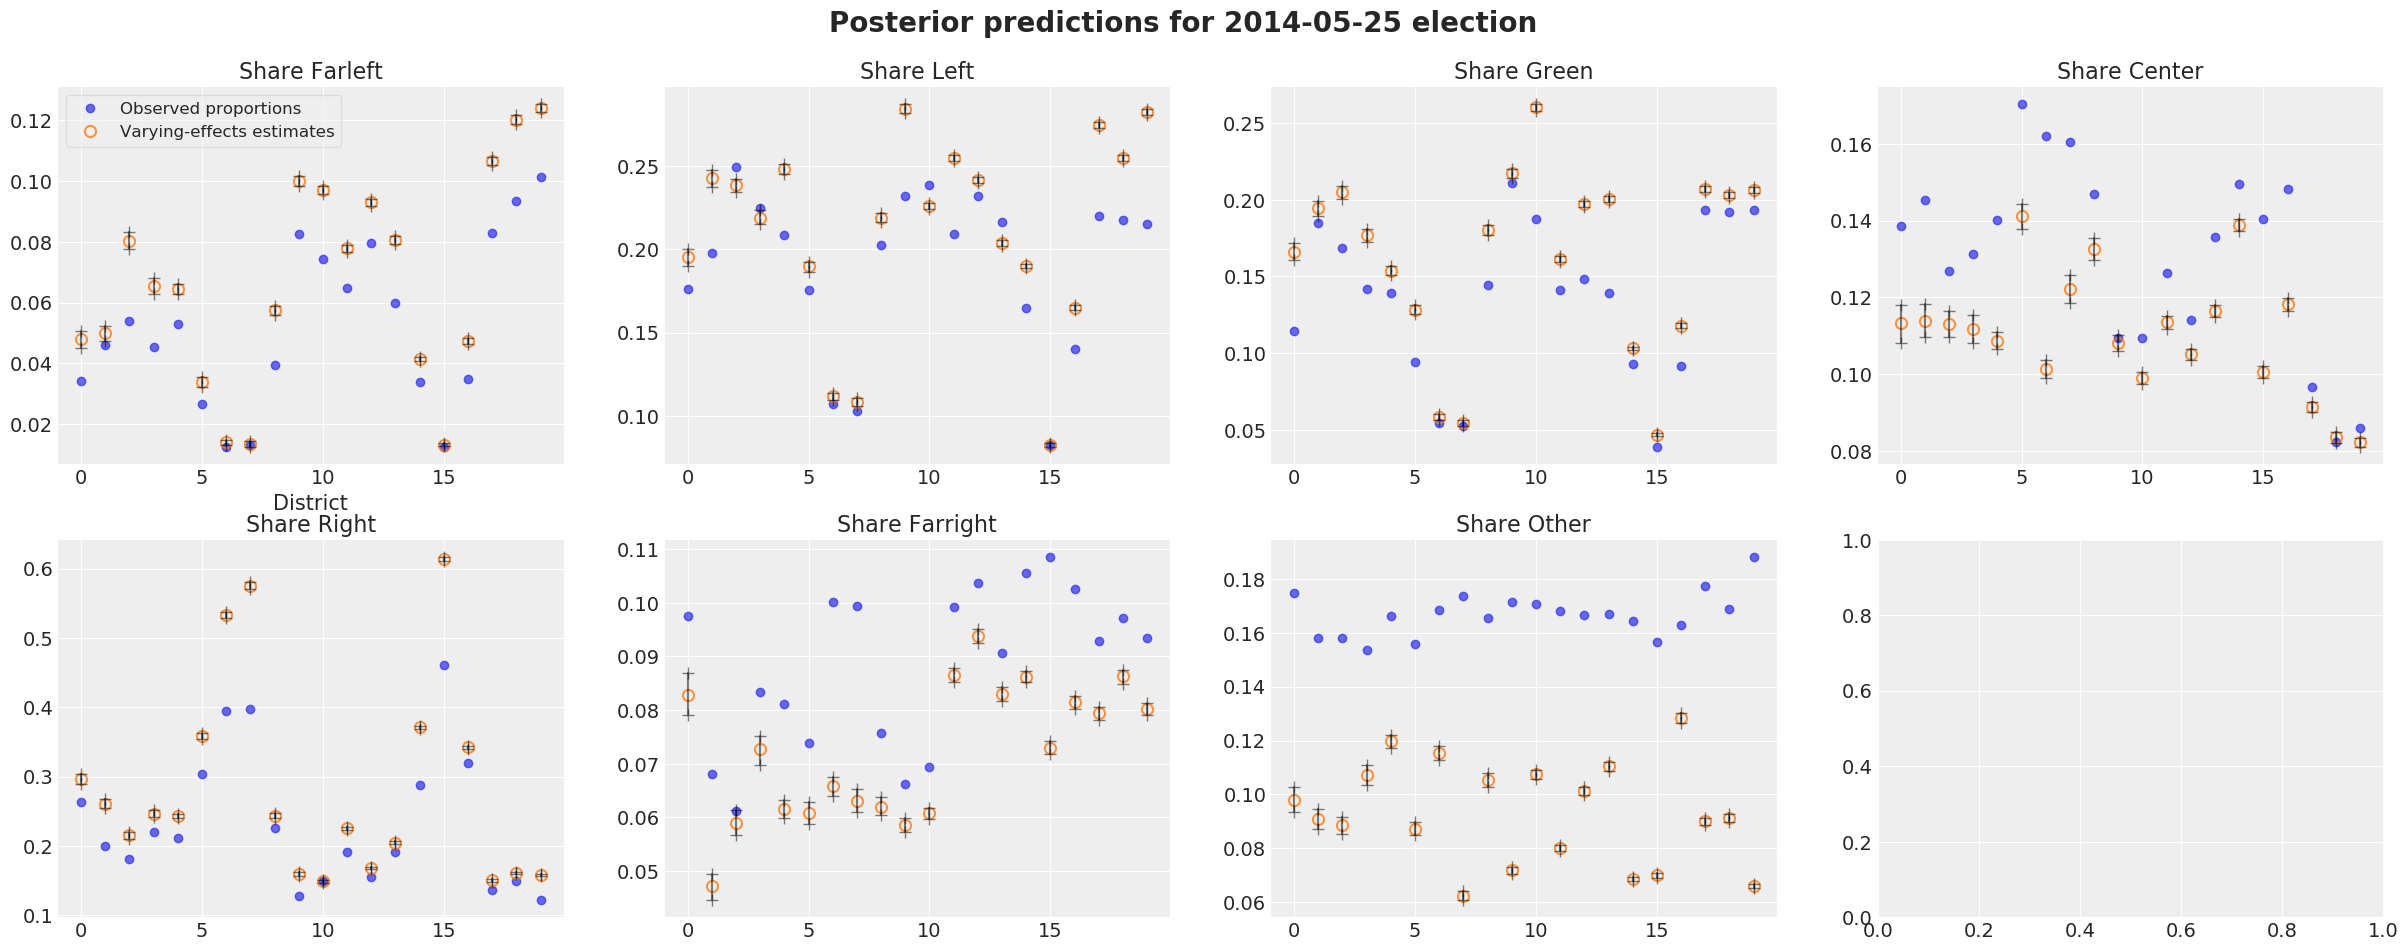

In [150]:
election = np.random.choice(d.date.unique())
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[election_mask, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, election_mask, i]).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5, fontsize=12)
    except IndexError:
        continue
fig.suptitle(
    f"Posterior predictions for {np.datetime_as_string(election, unit='D')} election",
    y=0.95,
    size=20,
    weight="bold",
);

In [11]:
# DO NOT RUN
%watermark -a AlexAndorra -n -u -v -iv

numpy  1.17.3
arviz  0.6.1
pandas 0.25.3
pymc3  3.8
AlexAndorra 
last updated: Sun Feb 09 2020 

CPython 3.7.6
IPython 7.11.1
